In [1]:
import os
from itertools import count

import shapefile
import contextily as cx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import geopandas
import osmnx as ox
import pandas as pd
from tqdm.auto import tqdm
from libpysal.cg import voronoi_frames
import momepy
import math
import shapely
shapely.speedups.disable()

DATA = "data"

/home/asia/.pyenv/versions/3.8.0/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
G = nx.read_gpickle(os.path.join(DATA, "spiw_peripheral_bike_and_investmap.gpickle"))
G=G.to_undirected()

In [3]:
for u, v, data in G.edges(data=True):
    if data["type"]=='closest_crossing':
        data["type"]='all_road'
    data["bike_counter"]=0


In [4]:
buildings=[node for node in G.nodes if G.nodes[node]["type"]=="building"]

In [5]:
bike_crossings=[node for node in G.nodes if G.nodes[node]["type"]=="bike_crossing"]

In [6]:
H = nx.Graph(((u, v, e) for u,v,e in G.edges(data=True) if e['type'] == 'all_road'))

In [7]:
def path_length(G, path): 
    return sum([list(dict(G[path[i]][path[i+1]]).values())[0]['length'] for i in range(len(path)-1)])

In [8]:
for u,v,e in G.edges(data=True):
    if e['type'] == 'bike_path':
        pt1=shapely.geometry.Point(G.nodes[u]['x'],G.nodes[u]['y'] )
        pt2=shapely.geometry.Point(G.nodes[v]['x'],G.nodes[v]['y'])
        points_df = geopandas.GeoDataFrame({'geometry': [pt1, pt2]}, crs='EPSG:4326').to_crs("EPSG:2177")
        e["length"]=points_df.distance(points_df.shift())[1]
#         print(points_df.distance(points_df.shift())[1])


In [9]:
path_from_building_to_bike_lengths = []


for b in tqdm(buildings):
    shortest_paths=nx.shortest_path(G, source=b,  weight='length') 
#     not_bike=[node for node in shortest_paths.keys() if G.nodes[node]["type"]!="bike_crossing" and G.nodes[node].get("additional")!="new_bike_path"]
    not_bike=[node for node in shortest_paths.keys() if G.nodes[node]["type"]!="bike_crossing"]

    for n in not_bike:
        shortest_paths.pop(n, None)
    shortest_path=(math.inf, math.inf)
    for key, shortest_tmp in shortest_paths.items():
        shortest_length=path_length(G,shortest_tmp)
        if shortest_length<shortest_path[1]:
            shortest_path=(shortest_tmp,shortest_length)
            
    path_from_building_to_bike_lengths.append(shortest_path[1])
    
    for i in range(len(shortest_path[0])-1):
        list(dict(G[shortest_path[0][i]][shortest_path[0][i+1]]).values())[0]['additional']="new_bike_path"
        list(dict(G[shortest_path[0][i]][shortest_path[0][i+1]]).values())[0]['bike_counter']+=1
        G.nodes[shortest_path[0][i]]["additional"]="new_bike_crossing"
        
    G.nodes[shortest_path[0][len(shortest_path[0])-1]]["additional"]="new_bike_crossing"

In [10]:
nx.write_gpickle(G, os.path.join(DATA, "shortest_paths_counter.gpickle")

In [2]:
G = nx.read_gpickle(os.path.join(DATA, "shortest_paths_counter.gpickle"))


In [3]:
G_nodes, G_streets = ox.graph_to_gdfs(G)

G_nodes = G_nodes.to_crs(epsg=2177)
G_streets = G_streets.to_crs(epsg=2177)

In [6]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 5):
    display(G_streets['bike_counter'].value_counts(dropna=False))

0     107204
1       6158
2       1457
3        553
4        402
5        193
6        180
8        126
9        116
7        100
10        94
11        41
14        39
12        27
13        26
43        19
15        19
22        15
16        14
36        13
27        12
20        12
17        12
26        10
19        10
31         9
25         8
18         7
33         6
21         5
24         3
38         3
23         1
35         1
39         1
Name: bike_counter, dtype: int64

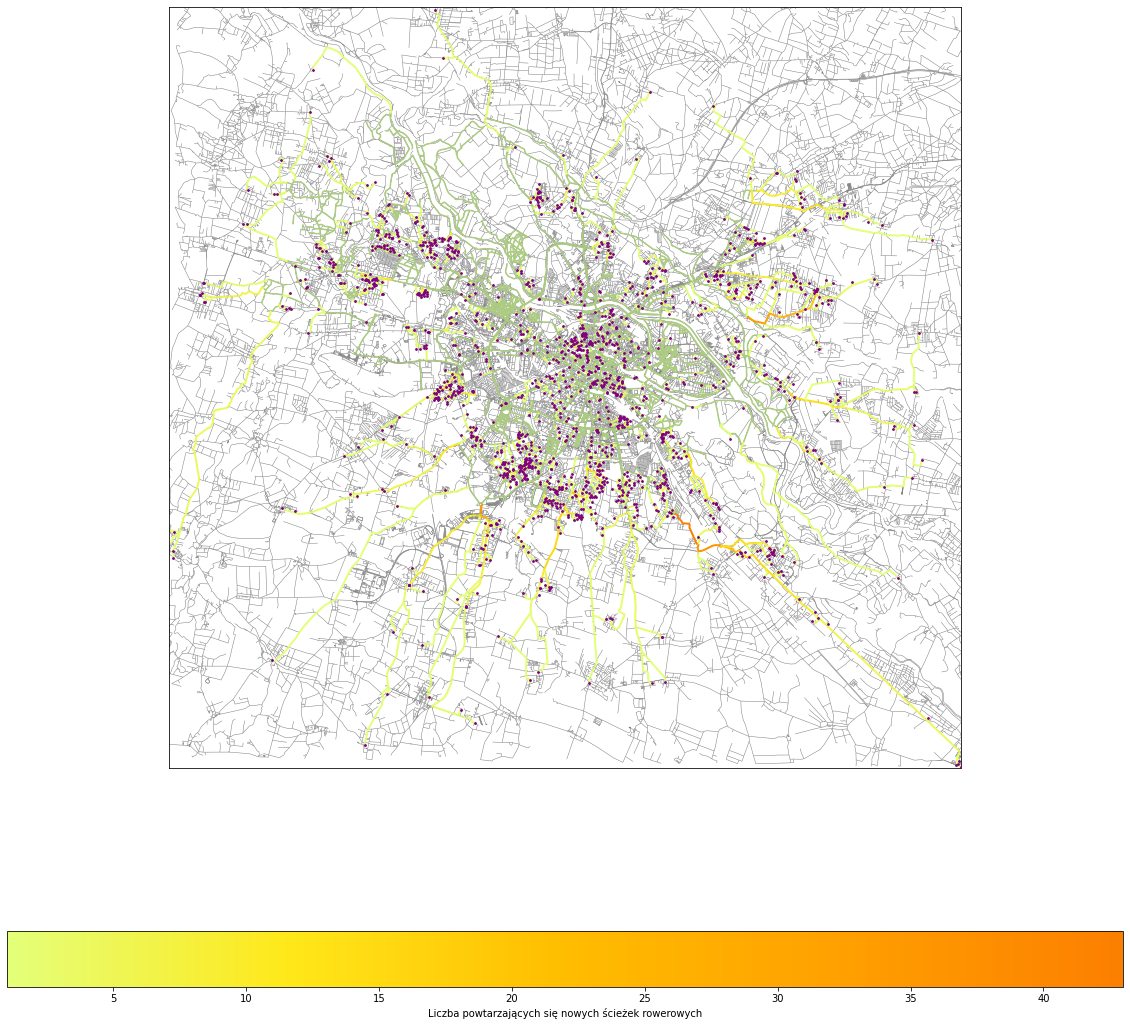

In [13]:
fig = plt.figure(figsize=(20,20))
ax = plt.subplot()
G_nodes[G_nodes['type'] == 'building'].plot(
    markersize=3, color='purple', ax=ax, zorder=7, label='Inwestycje'
)

G_streets[G_streets['type'] == 'all_road'].plot(
    ax=ax, alpha=1, linewidth=0.5, edgecolor='gray', label='Wszystkie drogi'
)
G_streets[G_streets['type'] == 'bike_path'].plot(
    ax=ax, alpha=1, linewidth=1.5, edgecolor='#adcc83', label='Istniejące ścieżki rowerowe'
)
G_streets[G_streets.get('additional') == 'new_bike_path'].plot(column='bike_counter', linewidth=2, ax=ax, legend=True, cmap='Wistia',
                

           legend_kwds={'label': "Liczba powtarzających się nowych ścieżek rowerowych",
                        'orientation': "horizontal"} )

ax.set_ylim(bottom=5.6461e6, top=5.6803e6)
ax.set_xlim(left=6.4134e6, right=6.449e6)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
# cx.add_basemap(ax=ax, crs=G_nodes.crs.to_string(), source=cx.providers.CartoDB.Voyager)
plt.savefig('image/bike_counter.png', dpi=400)